<a href="https://colab.research.google.com/github/drSigPro/CNN-Classifier-Analysis/blob/main/compare_ImageNetModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Benchmarking and Comparing Performance of ImageNet Pre-trained Popular Classification Models

This code evaluates and compares the performance of popular pre-trained image classification models (AlexNet, VGG19, GoogleNet, ResNet101, DenseNet121, MobileNet_v2) using a subset of ImageNet images.
The code performs the following steps:

1. Loads pre-trained models from the torchvision library.
2. Creates an ImageNet dataset and dataloader for the ImageNet sample images.
3. Evaluates each model by calculating its inference time, model size, and FLOPs.
4. Computes and reports the top-1 and top-5 accuracy of each model on the ImageNet samples.
5. Generates bar plots to visualize the performance comparison of the models across different metrics (inference time, model size, FLOPs, and accuracies).

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import time
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random

In [ ]:
!pip install torchprofile # Install torchprofile for FLOPs
from torchprofile import profile_macs

In [ ]:
# Load the models (You can try loading other models also, but ensure its compatible with input size of 224x224 and also pre-trained on ImageNet)
from torchvision import models
from torchvision.models import alexnet, vgg19, googlenet, resnet101, densenet121, mobilenet_v2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We will be using the sample ImageNet dataset available in https://github.com/EliSchwartz/imagenet-sample-images.

A subset of 100 images is shared at https://drive.google.com/file/d/1ws6fnkXjbEINK-id-IuU4vZlTKiUDYDg/view?usp=sharing

Download to your Gdrive and update the path below

In [ ]:
# Path to your compressed file in Google Drive
zip_path = '/content/drive/MyDrive/AAI3001/Datasets/ImageNetSamples.zip' # Make sure the path to your drive folder is updated!
ROOT = '/content'
datasets.utils.extract_archive(zip_path, ROOT) # Observe if the folder with name ImageNetSamples is created on the left pane <--

'/content'

Define an ImageNetDataset class provides a way to load and access images from a folder, extract their labels, and apply transformations. This is as per the ImageNet datastyle

In [ ]:
class ImageNetDataset(Dataset):
    def __init__(self, image_folder, class_list, transform=None):
        """
        Args:
            image_folder (str): Path to the folder containing images.
            class_list_file (str): Path to the file containing ImageNet class list.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_folder = image_folder
        self.transform = transform

        # Load ImageNet class list from file
        self.class_list = class_list

        # List all images in the folder
        self.image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Extract class label from the image filename
        # Assuming the class name is represented as part of the filename, e.g., "n01440764_sea_urchin.JPEG"
        class_name = '_'.join(img_name.split('_')[1:]).split('.')[0]  # Extracting "sea_urchin" from "n01440764_sea_urchin.JPEG"
        label = self.class_list.index(class_name) if class_name in self.class_list else -1

        if self.transform:
            image = self.transform(image)

        return image, label

Create transform as per the ImageNet dataset

In [ ]:
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor(),
 transforms.Normalize(
 mean=[0.485, 0.456, 0.406],
 std=[0.229, 0.224, 0.225]
 )])

The ImageNet classes (1000 class) is defined in the text file. Please download the same from the link: https://drive.google.com/file/d/1TfR3LfjbDYC8TN-KO1Tg34TtiFSUT4EL/view?usp=sharing and upload to your Gdrive and update the path below.

In [ ]:
with open('/content/drive/MyDrive/AAI3001/Datasets/imagenet_classes.txt') as f: #Update the path as per the location of the text file
  classes = [line.strip().split(', ')[1] for line in f.readlines()]

Instantiate the dataset and dataloader


In [ ]:
dataset = ImageNetDataset(image_folder='/content/ImageNetSamples',class_list = classes, transform=transform)

BATCH_SIZE = 64
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

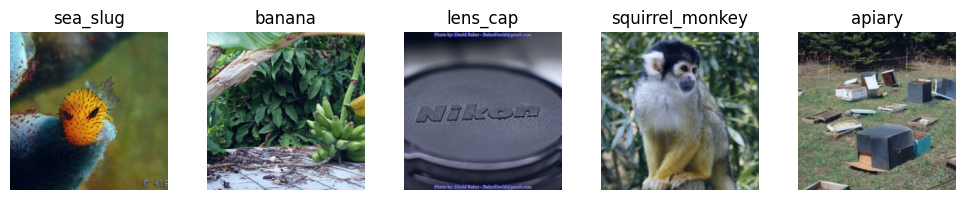

In [ ]:
# Display some sample images with class names
N = 5

# Get one batch from the test_iterator
data_iter = iter(dataloader)
images, labels = next(data_iter)  # Fetch one batch using next()

# Randomly select N samples from the batch
random_indices = random.sample(range(BATCH_SIZE), N)
random_images = images[random_indices]
random_labels = labels[random_indices]

# Plot the random images
fig, axes = plt.subplots(1, N, figsize=(N * 2, 2))
for i in range(N):
    img = random_images[i].permute(1, 2, 0)  # Reorder the tensor for plotting (channels last)
    # Normalize the image data to [0, 1]
    img = (img - img.min()) / (img.max() - img.min())
    axes[i].imshow(img.numpy())  # Convert tensor to numpy for display
    axes[i].set_title(f"{classes[random_labels[i].item()]}")
    axes[i].axis('off')  # Hide axes for cleaner visualization

plt.tight_layout()
plt.show()

The below function assesses how often the correct label is within the top k predictions made by the model, providing a measure of its performance. Historically, for the ImageNet challenge the models are evaluated for top 1% and 5% accuracy.

Top-k Accuracy = (Number of Correct Top-k Predictions) / (Total Number of Predictions)

Where:

Number of Correct Top-k Predictions: This is the count of instances where the true label is among the top k predictions made by the model for a given sample.
Total Number of Predictions: This is simply the total number of samples being evaluated.

In [ ]:
def calculate_topk_accuracy(y_pred, y_act, k = 5):
    with torch.no_grad():
        batch_size = y_act.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y_act.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

Function provides a way to quantify how fast, large, computationally complex, and accurate a given machine learning model is when applied to a specific dataset.

In [ ]:
# Function to evaluate model inference time, size, and FLOPs
def evaluate_model(model, dataloader, criterion, device):

    # Move model to device (GPU or CPU)
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    inference_time = []
    acc_1_accum = []
    acc_k_accum = []
    count = 0

    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            # Inference Time
            start_time = time.time()
            output = model(image)
            end_time = time.time()
            inference_time.append((end_time - start_time)/image.shape[0])
            count += 1
            # Calculate accuracy
            #_, predicted = torch.max(output, 1)
            acc_1, acc_k = calculate_topk_accuracy(output, label, k = 5)
            acc_1_accum.append(acc_1)
            acc_k_accum.append(acc_k)

    inference_time = sum(inference_time) / count
    acc_1_accum = sum(acc_1_accum) / count
    acc_k_accum = sum(acc_k_accum) / count

    # Print results
    print(f"Inference Time: {inference_time:.4f} seconds")
    # Model Size
    torch.save(model.state_dict(), "temp.pth")
    model_size = os.path.getsize("temp.pth") / (1024 * 1024)  # Convert to MB
    os.remove("temp.pth")

    # FLOPs
    example_input = torch.randn(1, 3, 224, 224).to(device)
    flops = profile_macs(model, example_input)

    return inference_time, model_size, flops, acc_1_accum, acc_k_accum

This code section loads six popular pre-trained image classification models (AlexNet, VGG19, GoogleNet, ResNet101, DenseNet121, and MobileNet_v2) and evaluates their performance on a subset of the ImageNet dataset.

In [ ]:
# Load Models
models = {
    "AlexNet": alexnet(pretrained=True),
    "VGG19": vgg19(pretrained=True),
    "GoogleNet": googlenet(pretrained=True),
    "ResNet101": resnet101(pretrained=True),
    "DenseNet121": densenet121(pretrained=True),
    "MobileNet_v2": mobilenet_v2(pretrained=True)
}

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss function
criterion = nn.CrossEntropyLoss()

# Evaluate all models
results = {}
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    inference_time, model_size, flops, acc_1_accum, acc_k_accum = evaluate_model(model, dataloader, criterion, device)
    results[model_name] = {
        "Inference Time (ms)": inference_time * 1000,
        "Model Size (MB)": model_size,
        "FLOPs (GigaFLOPs)": flops / 1e9,
         "1% Accuracy ": acc_1_accum.cpu().numpy()[0] * 100,
        "5% Accuracy": acc_k_accum.cpu().numpy()[0] * 100
    }

results_df = pd.DataFrame(results).T
print(results_df)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 61.9MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be remove

Evaluating AlexNet...
Inference Time: 0.0063 seconds
Evaluating VGG19...
Inference Time: 0.0003 seconds
Evaluating GoogleNet...
Inference Time: 0.0030 seconds


/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unsqueeze". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


Evaluating ResNet101...
Inference Time: 0.0007 seconds
Evaluating DenseNet121...
Inference Time: 0.0019 seconds
Evaluating MobileNet_v2...
Inference Time: 0.0006 seconds
              Inference Time (ms)  Model Size (MB)  FLOPs (GigaFLOPs)  \
AlexNet                  6.330662       233.085978           0.714198   
VGG19                    0.290310       548.057653          19.632088   
GoogleNet                2.952313        25.424055           1.501754   
ResNet101                0.674636       170.505901           7.817639   
DenseNet121              1.862802        30.974475           2.850006   
MobileNet_v2             0.576278        13.586613           0.307454   

              1% Accuracy   5% Accuracy  
AlexNet          73.784721    89.583337  
VGG19            88.975692    95.659721  
GoogleNet        74.826390    91.145837  
ResNet101        89.756942    99.218750  
DenseNet121      84.461808    97.829860  
MobileNet_v2     90.190971    95.659721  


Display the results as bar chart

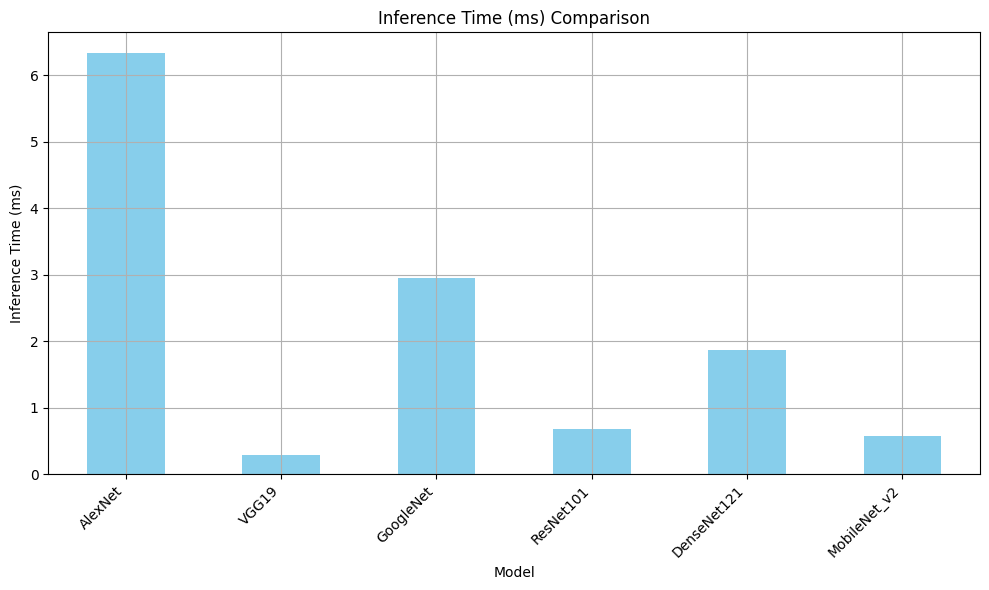

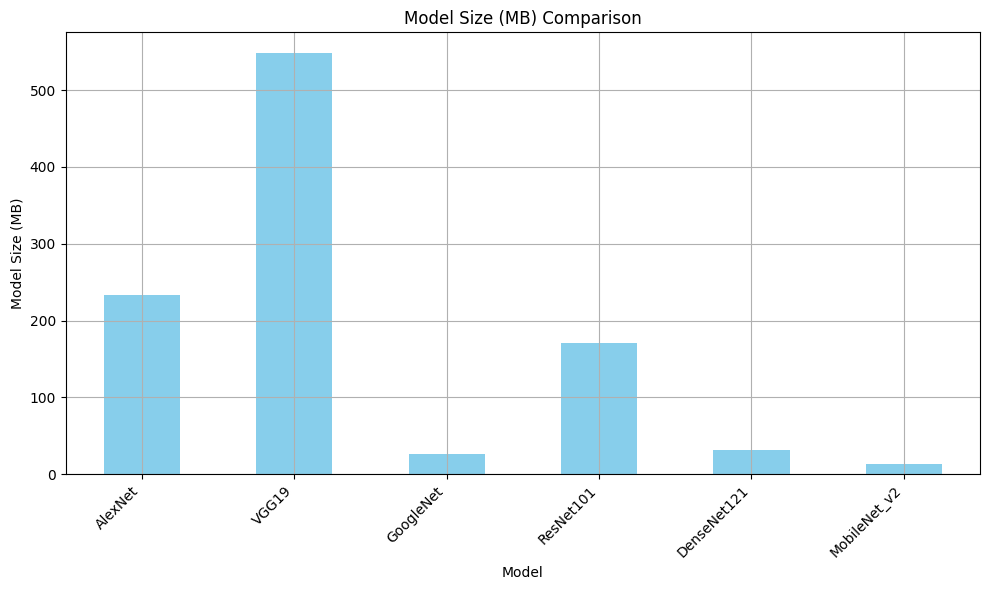

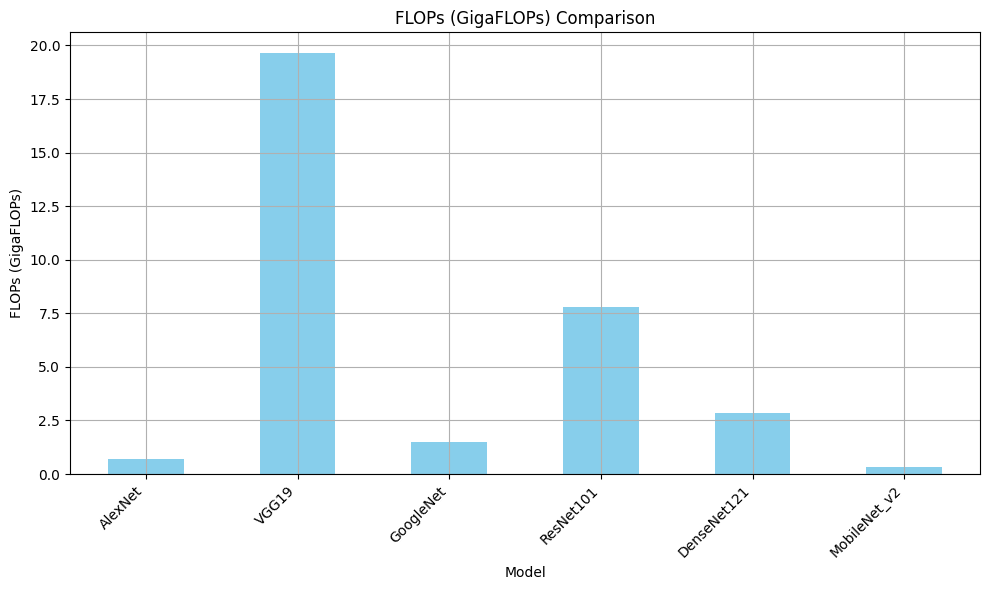

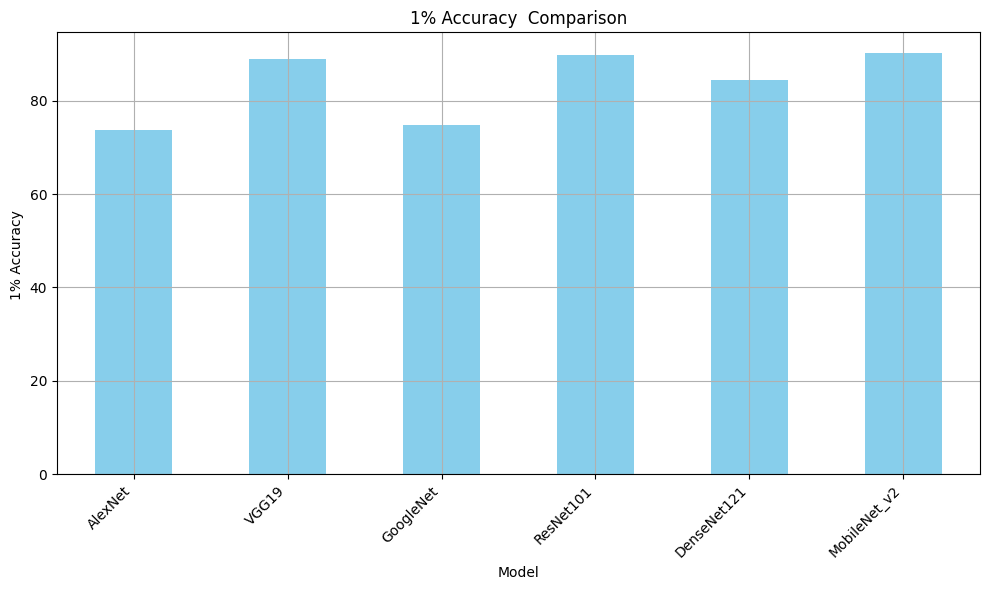

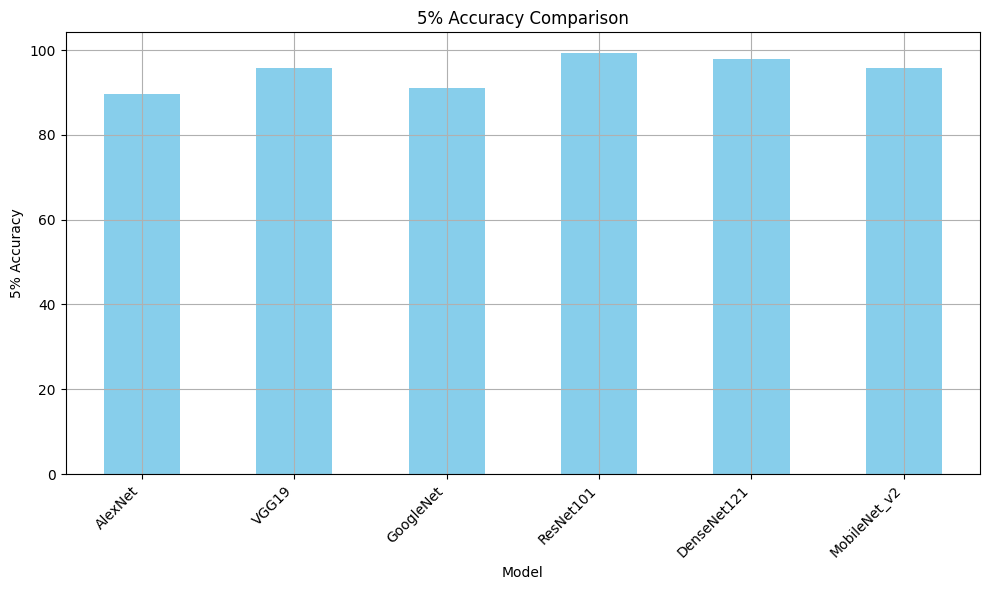

In [ ]:
results_df = pd.DataFrame(results).T

# Create individual bar plots for each metric
# Include accuracy metrics in the list
metrics = ['Inference Time (ms)', 'Model Size (MB)', 'FLOPs (GigaFLOPs)', '1% Accuracy ', '5% Accuracy']

for metric in metrics:
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    results_df[metric].plot(kind='bar', color='skyblue')

    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.grid(True)
    plt.tight_layout()

    plt.show()

# To do as home work


1. What is your inference on which model to be used if the dataset is closer to ImageNet dataset?
2. You can try to change the input image size to say 128x128 (e.g. set transforms.Resize(128)) and 256x256 and infer the results based on the bar plots? What is the reason we can feed in any sized image?
3. Change the batch size to 1 and observe the changes in inference time and accuracy. What is your inference?